# Compare Reconstruction Algo
This script performs FBP, SIRT and CGLS reconstructions of a phantom sample. The reconstructions are compared using several
image quality indexes.

In [65]:
import numpy as np
import neutompy as ntp
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

import time

In [2]:
#%% some handy function definitions
def imshow(image, limits, title=''):
    """Usage: imshow(image, [min,max], title)"""
    plt.title(title)
    bitmap = plt.imshow(image)
    if len(limits)==0:
        limits = [image.min(), image.max()]

    plt.clim(limits[0], limits[1])
    plt.colorbar(shrink=.6)
    plt.axis('off')
    return bitmap

Define some parameters like the pixel size of the detector (in cm -> attenuation cm^-1) and a factor (θ) to reduce the number of projections (crop image):

In [3]:
# pixel size in cm
pixel_size = 0.0029

# factor to reduce the number of projections in the sinogram
skip_theta = 3

# image filename
fname = './data/sinogram.tiff'
print(fname)

./data/sinogram.tiff


## Read and visualize data
Read the sinograms in arrays and plot them:

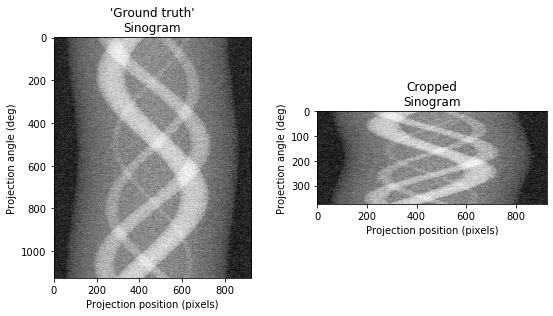

In [4]:
# read the sinogram
sino_hq = ntp.read_image(fname)
na     = sino_hq.shape[0]

# angles views in radians
angles = np.linspace(0, 2*np.pi, na, False)[::skip_theta]

# reduce number of projections in the sinogram
sino   = sino_hq[::skip_theta]

# plot sinograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.set_title("'Ground truth'\nSinogram")
ax1.set_xlabel("Projection position (pixels)")
ax1.set_ylabel("Projection angle (deg)")
ax1.imshow(sino_hq, cmap=plt.cm.Greys_r)

ax2.set_title("Cropped\nSinogram")
ax2.set_xlabel("Projection position (pixels)")
ax2.set_ylabel("Projection angle (deg)")
ax2.imshow(sino, cmap=plt.cm.Greys_r)

fig.tight_layout()
plt.show()

## Reconstruction
Reconstruction of a ground truth image ('original' sinogram), and the cropped sinogram (with three different algorithms)
- FBP
- SIRT (200 iterations)
- CGLS (10 iterations)

In [5]:
# ground truth reconstruction
true = ntp.reconstruct(sino_hq, np.linspace(0, np.pi*2, sino_hq.shape[0], endpoint=False), 'SIRT',
                        {'iterations':200}, pixel_size=pixel_size)
# fbp reconstruction
start = time.time()
fbp  = ntp.reconstruct(sino, angles, 'FBP', pixel_size=pixel_size)
stop = time.time()
print('Duration FBP: {:.2f}s'.format(stop-start))

# sirt reconstruction
start = time.time()
sirt = ntp.reconstruct(sino, angles, 'SIRT', parameters={'iterations':200}, pixel_size=pixel_size)
stop = time.time()
print('Duration SIRT (200 iter): {:.2f}s'.format(stop-start))

# cgls reconstruction
start = time.time()
cgls = ntp.reconstruct(sino, angles, 'CGLS', parameters={'iterations':10}, pixel_size=pixel_size)
stop = time.time()
print('Duration CGLS (10 iter): {:.2f}s'.format(stop-start))

## Plot: Compare FBP, SIRT and CGLS


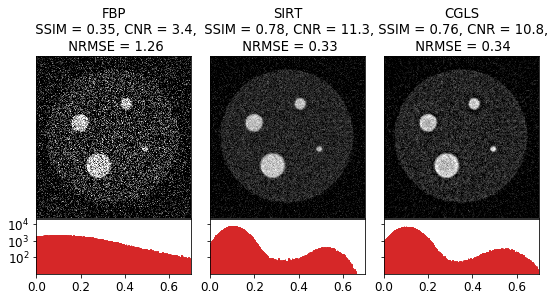

In [6]:
# define a list of reconstructed images
rec_list = [fbp, sirt, cgls]
rec_name = ['FBP', 'SIRT', 'CGLS']

# roi coordinates
rmin = 0
rmax = None
cmin = 0
cmax = 880

# set the x-axis range of the histograms
xmin = 0.0
xmax = 0.7

# counts range of the histograms
ymin = 10
ymax = 2e4

nsquare = 3
nbins = 300

[binning, width] = np.linspace(xmin, xmax, nbins, retstep=True)

nsubplot = len(rec_list)

plt.rc('font', family='serif', serif='Times', size=11)
plt.rc('text', usetex=False)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)


fig = plt.figure(figsize=(nsquare*nsubplot, nsquare+1+0.5))
fig.subplots_adjust(hspace=0, wspace=0.5, top=0.8)
gs = GridSpec(nsquare+1, nsquare*nsubplot)

for i in range(0, nsubplot):

    ax1 = fig.add_subplot(gs[0:nsquare, i*nsquare:(i+1)*nsquare])
    # quality metrics evaluation
    img = rec_list[i]
    im = ax1.imshow(img[rmin:rmax, cmin:cmax], vmin=xmin, vmax=xmax, cmap='gray')
    ssim  = ntp.SSIM(img, true)
    nrmse = ntp.NRMSE(img, true)
    cnr   = ntp.CNR(img, froi_signal='./data/signal.roi', froi_background='./data/background.roi')

    title = rec_name[i]
    plt.title(title +  '\n SSIM = '+ "{:.2f}".format(ssim) + ', CNR = ' "{:.1f}".format(cnr) + ',\n NRMSE = '+ "{:.2f}".format(nrmse))
    plt.xticks([])
    plt.yticks([])

    ax2 = fig.add_subplot(gs[nsquare, i*nsquare:(i+1)*nsquare]) 
    # generate histogram of the gray values inside a circular mask
    mask = ntp.get_circular_mask(img.shape[0], img.shape[1], radius=370, center=(img.shape[0]//2, img.shape[0]//2 -30))
    cc, edge = np.histogram(img[mask], bins=binning)
    ax2.bar(edge[:-1]+width*0.5, cc, width, color='C3', edgecolor='C3', log=True)
    plt.xlim([0, xmax])
    plt.ylim([ymin, ymax])
    plt.yticks([1e2, 1e3, 1e4], ['']*3)
    if i == 0:
        plt.yticks([1e2, 1e3, 1e4], ['$10^2$', '$10^3$', '$10^4$'])


plt.show()

## Add noise
- Gaussian
- Poisson: Poisson noise is signal dependent! (to make it signal dependent pass the image to the NumPy's poisson function)

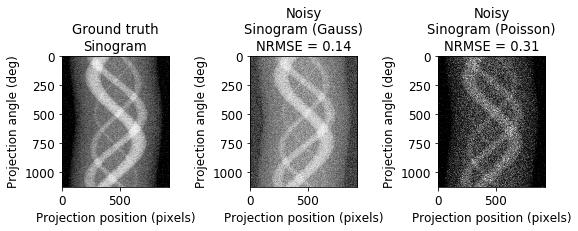

In [7]:
# gaussian noise, modify to adjust how 'salty' the sinogram is
row,col= sino_hq.shape
mean = 0
var = 0.03
sigma = var**0.99
gauss = np.random.normal(mean,sigma,(row,col))
gauss = gauss.reshape(row,col)
noisy_gauss = sino_hq + gauss

# poisson noise
sino_hq[sino_hq < 0] = 0.0
vals = len(np.unique(sino_hq))
vals = 1.2 ** np.ceil(np.log2(vals))
noisy_poisson = np.random.poisson(sino_hq * vals) / float(vals)
# Alternative:
# noisy_array=np.random.poisson(sino_hq).astype('float64')
# noisy_poisson = sino_hq + 0.1*noisy_array

# plot sinograms
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 4.5))

ax1.set_title("Ground truth\nSinogram")
ax1.set_xlabel("Projection position (pixels)")
ax1.set_ylabel("Projection angle (deg)")
ax1.imshow(sino_hq, cmap=plt.cm.Greys_r)

ax2.set_title("Noisy\nSinogram (Gauss)\nNRMSE = {:.2f}".format(ntp.NRMSE(noisy_gauss, sino_hq)))
ax2.set_xlabel("Projection position (pixels)")
ax2.set_ylabel("Projection angle (deg)")
ax2.imshow(noisy_gauss, cmap=plt.cm.Greys_r)

ax3.set_title("Noisy\nSinogram (Poisson)\nNRMSE = {:.2f}".format(ntp.NRMSE(noisy_poisson, sino_hq)))
ax3.set_xlabel("Projection position (pixels)")
ax3.set_ylabel("Projection angle (deg)")
ax3.imshow(noisy_poisson, cmap=plt.cm.Greys_r)

fig.tight_layout()
plt.show()

## Reconstruction of noisy images
### Taking control of the iteration process
We will now show how to run each iteration from in Python, as opposed to letting the reconstructor do all iterations at once.

In [67]:
iterations = [0,1,2,4,8]

all_images = np.ndarray(shape=(len(iterations),) + sirt.shape)

for num,i in enumerate(iterations):
    print('Step {} with iteration {}'.format(num, i))
    start = time.time()
    if i == 0:
        all_images[num,:,:] = np.zeros(sirt.shape)
        stop = time.time()
        print('Duration: {:.2f}s'.format(stop-start))
    else:
        noisy = noisy_poisson[::skip_theta]
        sirt = ntp.reconstruct(noisy, angles, 'SIRT', parameters={'iterations':i}, pixel_size=pixel_size)
        all_images[num,:,:] = sirt
        stop = time.time()
        print('Duration: {:.2f}s'.format(stop-start))

#print(all_images)

Step 0 with iteration 0
Duration: 0.00s
Step 1 with iteration 1
Duration: 5.74s
Step 2 with iteration 2
Duration: 10.56s
Step 3 with iteration 4
Duration: 19.48s
Step 4 with iteration 8
Duration: 37.04s
[[[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[ 0.05874246  0.05860017  0.05602751 ...  0.05211782  0.05115242
    0.05073868]
  [ 0.05788343  0.06036309  0.05712675 ...  0.05104711  0.05101108
    0.05142175]
  [ 0.054686    0.05880255  0.0597676  ...  0.0505274   0.05152522
    0.0497996 ]
  ...
  [ 0.05903856  0.05837446  0.05735866 ...  0.05514499  0.05224208
    0.05217573]
 

### Make some plots with these results

In [68]:
# save max for future displays
cmax = true.max()

# define a function for plotting images and the updates
def plot_progress(all_images, title, iterations = []):
    num_rows = len(all_images)
    for num, i in enumerate(iterations):
        plt.figure()
        for r in range(num_rows):
            plt.subplot(num_rows,2,2 * r + 1)
            imshow(all_images[r][num,:,:], [0,cmax], '%s at %d' % (title[r], i))
            plt.subplot(num_rows,2,2*r+2)
            imshow(all_images[r][num,:,:]-all_images[r][num - 1,:,:],[-cmax*.1,cmax*.1], 'update')
        plt.show()

now call this function to see how we went along (note that in the notebook interface, this might create a box with a vertical slider)

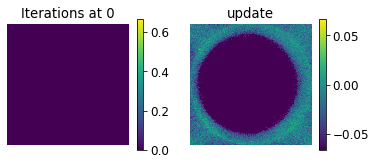

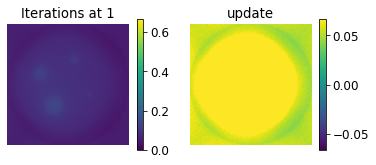

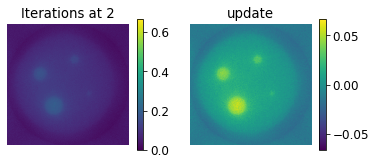

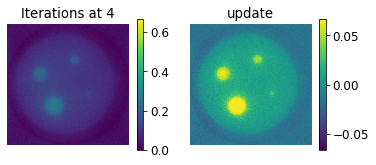

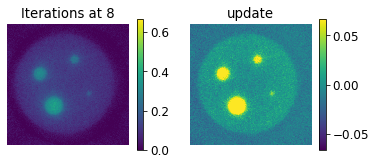

In [69]:
plot_progress([all_images], ['Iterations'], iterations)